# Spike centered plot
based on conversations with Robert and Ted Carnevale.


In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from neuron import h
h.load_file("stdrun.hoc")
sys.path.insert(1, "../utils/")
import HH, WB, Stimuli
import matplotlib as mpl
import random

## Hyperparameters

In [2]:
stim_types = ['base','lw','lt','lwlt','burst']
figures_dir = '../figures/'

sim_duration = 100000

e_times = Stimuli.poisson_process_duration(5, sim_duration)
i_times = Stimuli.poisson_process_duration(15, sim_duration)

stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold

for stim_type in stim_scaffold:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [3]:
sims = {stim_type:HH.HH() for stim_type in stim_types}

for stim_type in stim_types:
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])
    sims[stim_type].run_simulation(sim_duration)

In [4]:
df_base = np.array([sims['base']._v, sims['base']._m, sims['base']._n, sims['base']._h]).T
df_hw = np.array([sims['lw']._v, sims['lw']._m, sims['lw']._n, sims['lw']._h]).T
df_lt = np.array([sims['lt']._v, sims['lt']._m, sims['lt']._n, sims['lt']._h]).T
df_hwlt = np.array([sims['lwlt']._v, sims['lwlt']._m, sims['lwlt']._n, sims['lwlt']._h]).T
df_burst = np.array([sims['burst']._v, sims['burst']._m, sims['burst']._n, sims['burst']._h]).T

## action potential variance

In [5]:
def get_spike_windows(df, spikes, prespike_window=100, postspike_window=100):
    spike_windows = []
    for spike in spikes[10:-10]:
        start = int((spike-prespike_window)*40)
        stop = int((spike+postspike_window)*40)
        spike_windows.append((df[start:stop, :]))
    spike_windows = np.stack(spike_windows)
    return spike_windows
spike_windows = get_spike_windows(df_base, np.array(sims['base'].spike_times))
spike_windows_hw = get_spike_windows(df_hw, np.array(sims['lw'].spike_times))
spike_windows_lt = get_spike_windows(df_lt, np.array(sims['lt'].spike_times))
spike_windows_hwlt = get_spike_windows(df_hwlt, np.array(sims['lwlt'].spike_times))
spike_windows_burst = get_spike_windows(df_burst, np.array(sims['burst'].spike_times))

print(len(sims['base'].spike_times), spike_windows.shape)
print(len(sims['lw'].spike_times), spike_windows_hw.shape)
print(len(sims['lt'].spike_times), spike_windows_lt.shape)
print(len(sims['lwlt'].spike_times), spike_windows_hwlt.shape)
print(len(sims['burst'].spike_times), spike_windows_burst.shape)

2155 (2135, 8000, 4)
1414 (1394, 8000, 4)
1805 (1785, 8000, 4)
2328 (2308, 8000, 4)
2958 (2938, 8000, 4)


In [6]:
# normalize
def normalize_vec(vec, axis=1):
    vec = vec - np.min(vec)
    vec = vec / np.max(vec)
    return vec

def normalize_df(spike_windows):
    return np.array(
        [normalize_vec(spike_windows[:,:,0]),
        normalize_vec(spike_windows[:,:,1]),
        normalize_vec(spike_windows[:,:,2]),
        normalize_vec(spike_windows[:,:,3])]
    )

spike_windows_norm = normalize_df(spike_windows)
spike_windows_norm_hw = normalize_df(spike_windows_hw)
spike_windows_norm_lt = normalize_df(spike_windows_lt)
spike_windows_norm_hwlt = normalize_df(spike_windows_hwlt)
spike_windows_norm_burst = normalize_df(spike_windows_burst)

In [7]:
spike_windows_vars = np.var(spike_windows_norm, axis=(0,1))
spike_windows_vars_hw = np.var(spike_windows_norm_hw, axis=(0,1))
spike_windows_vars_lt = np.var(spike_windows_norm_lt, axis=(0,1))
spike_windows_vars_hwlt = np.var(spike_windows_norm_hwlt, axis=(0,1))
spike_windows_vars_burst = np.var(spike_windows_norm_burst, axis=(0,1))

In [8]:
def state_variable_vars(spike_windows_norm):
    v_vars = np.var(spike_windows_norm[0,:], axis=(0))
    h_vars = np.var(spike_windows_norm[1,:], axis=(0))
    n_vars = np.var(spike_windows_norm[2,:], axis=(0))
    m_vars = np.var(spike_windows_norm[3,:], axis=(0))
    return v_vars, h_vars, n_vars, m_vars
v_vars, h_vars, n_vars, m_vars = state_variable_vars(spike_windows_norm)
v_vars_hw, h_vars_hw, n_vars_hw, m_vars_hw = state_variable_vars(spike_windows_norm_hw)
v_vars_lt, h_vars_lt, n_vars_lt, m_vars_lt = state_variable_vars(spike_windows_norm_lt)
v_vars_hwlt, h_vars_hwlt, n_vars_hwlt, m_vars_hwlt = state_variable_vars(spike_windows_norm_hwlt)
v_vars_burst, h_vars_burst, n_vars_burst, m_vars_burst = state_variable_vars(spike_windows_norm_burst)

In [60]:
def spike_center_plot(spike_windows, v_vars, h_vars, n_vars, m_vars, prespike_window=100, postspike_window=100, savefile=None):
    fig, ax = plt.subplots(figsize=(6.5,2.5))
    
    _t = np.arange(0, prespike_window+postspike_window, 1/40)
    
    num_traces = min(1000, spike_windows.shape[0])

    for i in range(num_traces):
        ax.plot(_t-prespike_window, spike_windows[i,:,0], c='black', alpha=0.01)

    ax2=ax.twinx()
    ax2.plot(_t-prespike_window, v_vars, c='purple')
    ax2.plot(_t-prespike_window, h_vars, c='red')
    ax2.plot(_t-prespike_window, n_vars, c='blue')
    ax2.plot(_t-prespike_window, m_vars, c='green')

    ax.set_ylabel('Membrane voltage (mV)')
    ax2.set_ylabel('Variance of normalized\nstate variables', color='red')
    ax2_yticks=np.arange(0,16,2)/100
    ax2.set_yticks(ax2_yticks)
    ax2.set_yticklabels(ax2_yticks, color='red')
    ax.set_xlabel('time (ms)')
    ax.set_xlim(0-prespike_window, postspike_window)
    
    ax2.legend(['Vm','h','n','m'])
    
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    plt.tight_layout()
    
    if savefile:
        plt.savefig(savefile+'.png', format='png', dpi=600)
        plt.savefig(savefile+'.svg', format='svg')
        
    
    plt.show()

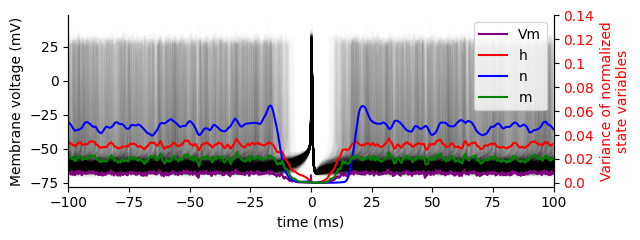

In [61]:
spike_center_plot(
    spike_windows, v_vars=v_vars, h_vars=h_vars, n_vars=n_vars, m_vars=m_vars, 
    savefile=f'{figures_dir}spike_centered_base')

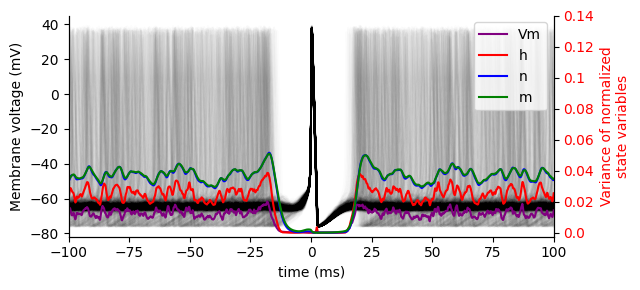

In [11]:
spike_center_plot(spike_windows_hw, v_vars_hw, h_vars_hw, n_vars_hw, m_vars_hw)

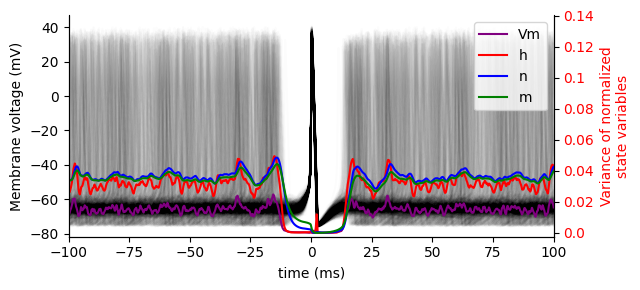

In [12]:
spike_center_plot(spike_windows_lt, v_vars_lt, h_vars_lt, n_vars_lt, m_vars_lt)

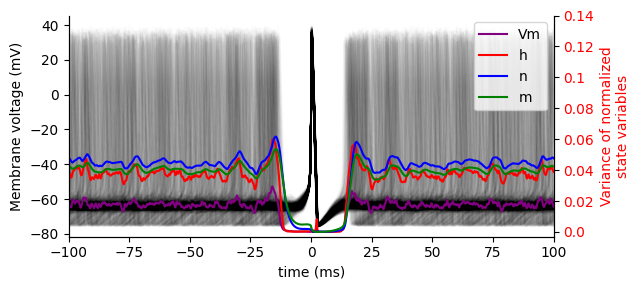

In [13]:
spike_center_plot(spike_windows_hwlt, v_vars_hwlt, h_vars_hwlt, n_vars_hwlt, m_vars_hwlt)

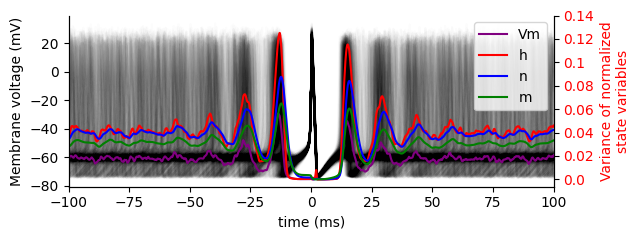

In [62]:
spike_center_plot(
    spike_windows_burst, v_vars_burst, h_vars_burst, n_vars_burst, m_vars_burst, 
    savefile=f'{figures_dir}spike_centered_burst')

## Spike centered plot for Wang Buzsaki neuron model
Running the previous models after executing this code will give different results, as the WB model sets NEURON's simulation temperature to 37C 

In [15]:
wb = WB.WB()
wb.add_custom_stimulus(stim_scaffold['wb']['ex'])
wb.add_custom_stimulus(stim_scaffold['wb']['in'])
wb.run_simulation(sim_duration)

In [16]:
df = np.array([wb._v, wb._m_kdr, wb._h_naf]).T
spikes = list(wb.spike_times)
spike_windows = get_spike_windows( df, spikes)
print(spike_windows.shape)

(2465, 8000, 3)


In [17]:
# these functions deal with 3 (for WB) variables instead of 4 (for HH)
def normalize_df(spike_windows):
    return np.array(
        [normalize_vec(spike_windows[:,:,0]),
        normalize_vec(spike_windows[:,:,1]),
        normalize_vec(spike_windows[:,:,2])]
    )

spike_windows_norm = normalize_df(spike_windows)
spike_windows_norm.shape

(3, 2465, 8000)

In [18]:
spike_windows_vars = np.var(spike_windows_norm, axis = (0,1))

In [19]:
def state_variable_vars(spike_windows_norm):
    v_vars = np.var(spike_windows_norm[0,:], axis=(0))
    m_vars = np.var(spike_windows_norm[1,:], axis=(0))
    h_vars = np.var(spike_windows_norm[2,:], axis=(0))
    return v_vars, m_vars, h_vars
v_vars, m_vars, h_vars = state_variable_vars(spike_windows_norm)

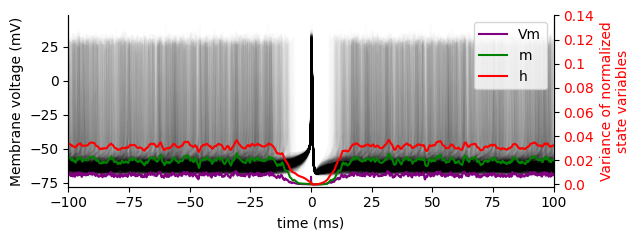

In [59]:
# this function is only different in that it deals with m and h only instead of m, h, and n
def spike_center_plot_WB(
    spike_windows, v_vars, m_vars, h_vars, prespike_window=100, postspike_window=100, savefile=None,
):
    fig, ax = plt.subplots(figsize=(6.5,2.5))
    
    _t = np.arange(0, prespike_window+postspike_window, 1/40)
    
    num_traces = min(1000, spike_windows.shape[0])

    for i in range(num_traces):
        ax.plot(_t-prespike_window, spike_windows[i,:,0], c='black', alpha=0.01)

    ax2=ax.twinx()
    ax2.plot(_t-prespike_window, v_vars, c='purple')
    ax2.plot(_t-prespike_window, m_vars, c='green')
    ax2.plot(_t-prespike_window, h_vars, c='red')

    ax.set_ylabel('Membrane voltage (mV)')
    ax2.set_ylabel('Variance of normalized\nstate variables', color='red')
    ax2_yticks=np.arange(0,16,2)/100
    ax2.set_yticks(ax2_yticks)
    ax2.set_yticklabels(ax2_yticks, color='red')
    ax.set_xlabel('time (ms)')
    ax.set_xlim(0-prespike_window, postspike_window)
    
    ax2.legend(['Vm','m','h'])
    
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    plt.tight_layout()
    
    if savefile:
        plt.savefig(savefile+'.png', format='png', dpi=600)
        plt.savefig(savefile+'.svg', format='svg')
        
    plt.show()
    
spike_center_plot_WB(spike_windows, v_vars, m_vars, h_vars, savefile=f'{figures_dir}spike_centered_wb')

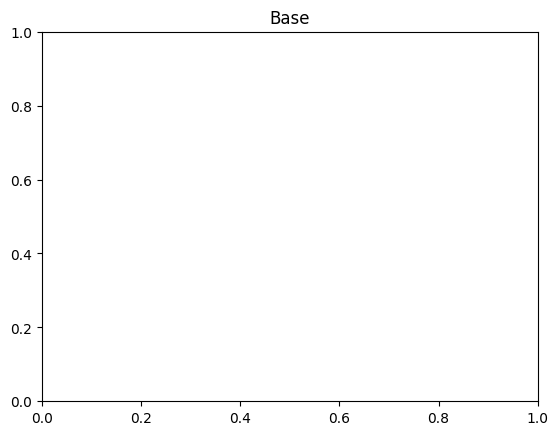

In [58]:
plt.title('WB')
plt.savefig(f'{figures_dir}wb.svg', format='svg')

plt.title('Burst')
plt.savefig(f'{figures_dir}burst.svg', format='svg')

plt.title('Base')
plt.savefig(f'{figures_dir}base.svg', format='svg')

## get the baseline state variable variance

In [22]:
print('base v var:', np.var(normalize_vec(df_base[:,0]), axis=(0)))
print('lw v var:', np.var(normalize_vec(df_hw[:,0]), axis=(0)))
print('lt v var:', np.var(normalize_vec(df_lt[:,0]), axis=(0)))
print('lwlt v var:', np.var(normalize_vec(df_hwlt[:,0]), axis=(0)))
print('burst v var:', np.var(normalize_vec(df_burst[:,0]), axis=(0)))
print('wb v var:', np.var(normalize_vec(df[:,0]), axis=(0)))

base v var: 0.01827678649086592
lw v var: 0.012132562433979255
lt v var: 0.014324453407071537
lwlt v var: 0.017674831785389932
burst v var: 0.01751929895495221
wb v var: 0.008047513496120004


In [42]:
np.argmax(v_vars[:4000])/40

69.025

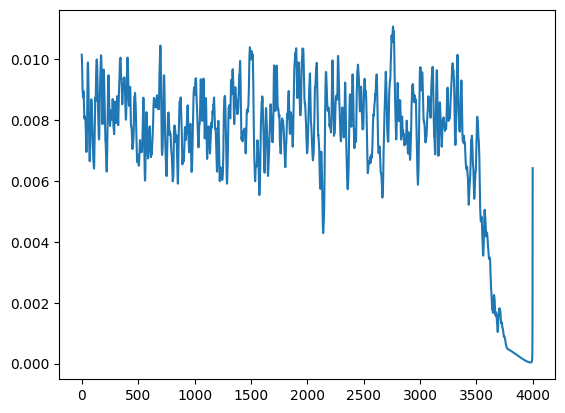

In [44]:
v_vars[:4000]

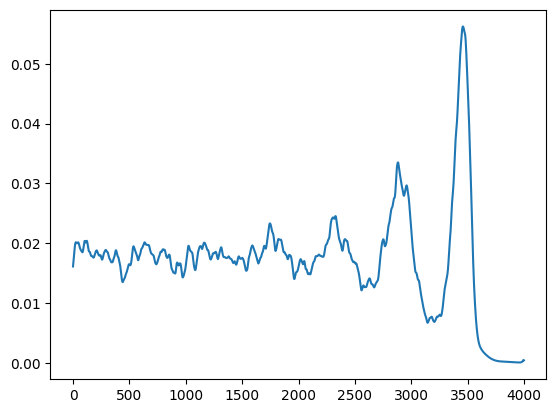

In [46]:
plt.plot(v_vars_burst[:4000])

In [24]:
print('min v var base:', np.min(v_vars))
print('min v var lw:', np.min(v_vars_hw))
print('min v var lt:', np.min(v_vars_lt))
print('min v var lwlt:', np.min(v_vars_hwlt))
print('min v var burst:', np.min(v_vars_burst))
print('min v var wb:', np.min(v_vars))

min v var base: 2.400768928985474e-05
min v var lw: 2.5744336472316627e-06
min v var lt: 1.865500800876483e-05
min v var lwlt: 1.1162261316677145e-05
min v var burst: 1.800358559737898e-05
min v var wb: 2.400768928985474e-05


In [25]:
print('percent v var base:', 
      np.min(v_vars) / np.var(normalize_vec(df_base[:,0]), axis=(0))*100)
print('percent v var lw:', 
      np.min(v_vars_hw) / np.var(normalize_vec(df_hw[:,0]), axis=(0))*100)
print('percent v var lt:', 
      np.min(v_vars_lt) / np.var(normalize_vec(df_lt[:,0]), axis=(0))*100)
print('percent v var lwlt:', 
      np.min(v_vars_hwlt) / np.var(normalize_vec(df_hwlt[:,0]), axis=(0))*100)
print('percent v var burst:', 
      np.min(v_vars_burst) / np.var(normalize_vec(df_burst[:,0]), axis=(0))*100)
print('percent v var wb:', 
      np.min(v_vars) / np.var(normalize_vec(df[:,0]), axis=(0))*100)

percent v var base: 0.13135618398700952
percent v var lw: 0.021219207906332582
percent v var lt: 0.13023190120158745
percent v var lwlt: 0.0631534231963888
percent v var burst: 0.10276430377535097
percent v var wb: 0.2983243122416596
